# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

[7. Choix du modèle pour le code final à déployer](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [3]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_1000t.csv', encoding='utf8')

In [4]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))

In [5]:
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))

In [6]:
sample_size = 10000

In [7]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

In [8]:
def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)

In [9]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences', 'jaccard_similarity']]
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)

In [10]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],
    test_size=0.5,
    random_state=42
)

In [11]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
sentences_list = sentences_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [12]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
sentences_list_eval = sentences_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
flat_tags_eval = [" ".join(tag) for tag in tags_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))
vocabulary_tags_eval = list(set([word for item in tags_list_eval for word in item]))

In [13]:
words = []
for text in flat_tags:
    words.extend(text.split())

counter = Counter(words)
top_500_tags = [word for word, count in counter.most_common(500)]

In [14]:
words = []
for text in flat_tags_eval:
    words.extend(text.split())

counter = Counter(words)
top_200_tags_eval = [word for word, count in counter.most_common(200)]

In [15]:
mlb = MultiLabelBinarizer(classes=top_500_tags)
tags_mlb = mlb.fit_transform(tags_list)

In [16]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1 & s2) / len(s1 | s2)

In [17]:
def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score

In [18]:
def plot_similar_tags(true_tags, pred_tags, method):
    mean_score = calculate_scores(true_tags, pred_tags)
    similar_counts = []
    
    for pred_tags, true_tags in zip(pred_tags, true_tags):
        similar_words = set(pred_tags) & set(true_tags)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    # Add missing keys to counter with value 0
    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14, fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0,6,1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n nombre de tags similaires", fontsize=12)   
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(), autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8}, title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n un nombre de tags similaires", fontsize=12)
    
    textstr = ''.join((
        r'Jaccard_index = %.2f' % (mean_score, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
    plt.show()

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Doc2Vec</font>

### Dataset d'essais

In [19]:
import multiprocessing
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [20]:
# Preprocess the sentences
sentences = [gensim.utils.simple_preprocess(text) for text in sentences_list]
true_tags = tags_list

In [21]:
tagged_data = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(sentences)]

# Train a Doc2Vec model
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)

# Use the trained model to infer vectors for each sentence
sentence_vectors = [d2v_model.infer_vector(sent) for sent in sentences]

# Find the most similar sentences for each sentence based on the inferred vectors
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=5) for vec in sentence_vectors]

# Convert the indices of similar sentences back to their respective tags
pred_tags = [[sentences[int(index)][0] for index, similarity in sim_sents] for sim_sents in similar_sentences]

In [22]:
pred_tags[0:5]

[['implementing', 'what', 'missing', 'how', 'spring'],
 ['playframework', 'what', 'spring', 'running', 'how'],
 ['how', 'bind', 'return', 'drawing', 'how'],
 ['what', 'how', 'can', 'could', 'how'],
 ['query', 'how', 'batchsize', 'execute', 'what']]

In [23]:
true_tags[0:5]

[['java', 'spring', 'rest', 'jpa', 'spring-data'],
 ['java', 'django', 'frameworks', 'comparison', 'playframework'],
 ['android', 'iphone', 'asp.net', 'web-services', 'push-notification'],
 ['java', 'spring', 'maven', 'spring-boot', 'maven-3'],
 ['java', 'sql', 'spring', 'jpa', 'spring-data-jpa']]

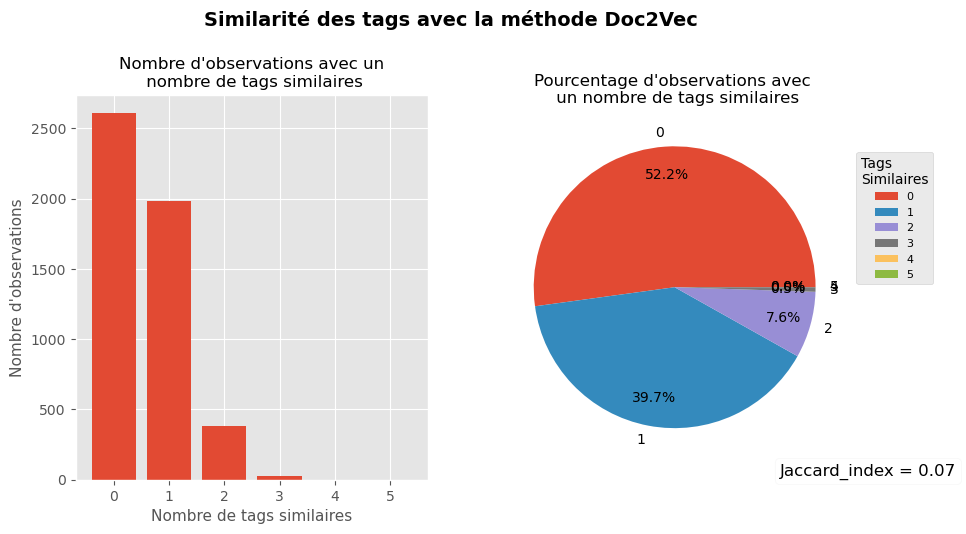

In [24]:
plot_similar_tags(true_tags, pred_tags, 'Doc2Vec')

# Avec top 500 tags

In [25]:
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=40) for vec in sentence_vectors]
pred_tags = []
for sim_sents in similar_sentences:
    used_tags = set()
    tags = [sentences[int(index)][0] for index, similarity in sim_sents if sentences[int(index)][0] in top_500_tags]
    pred_tags_filtered = [tag for tag in tags if tag not in used_tags and (used_tags.add(tag) or True)][:5]
    pred_tags.append(pred_tags_filtered)

In [26]:
pred_tags[0:5]

[['spring', 'django', 'jackson', 'java', 'python'],
 ['spring', 'django', 'python', 'replace', 'netbeans'],
 ['return', 'jackson', 'twitter', 'spring', 'rest'],
 ['cmake', 'java', 'maven', 'gradle', 'hibernate'],
 ['jpa', 'spring', 'hibernate', 'sqlalchemy', 'sql']]

In [27]:
true_tags[0:5]

[['java', 'spring', 'rest', 'jpa', 'spring-data'],
 ['java', 'django', 'frameworks', 'comparison', 'playframework'],
 ['android', 'iphone', 'asp.net', 'web-services', 'push-notification'],
 ['java', 'spring', 'maven', 'spring-boot', 'maven-3'],
 ['java', 'sql', 'spring', 'jpa', 'spring-data-jpa']]

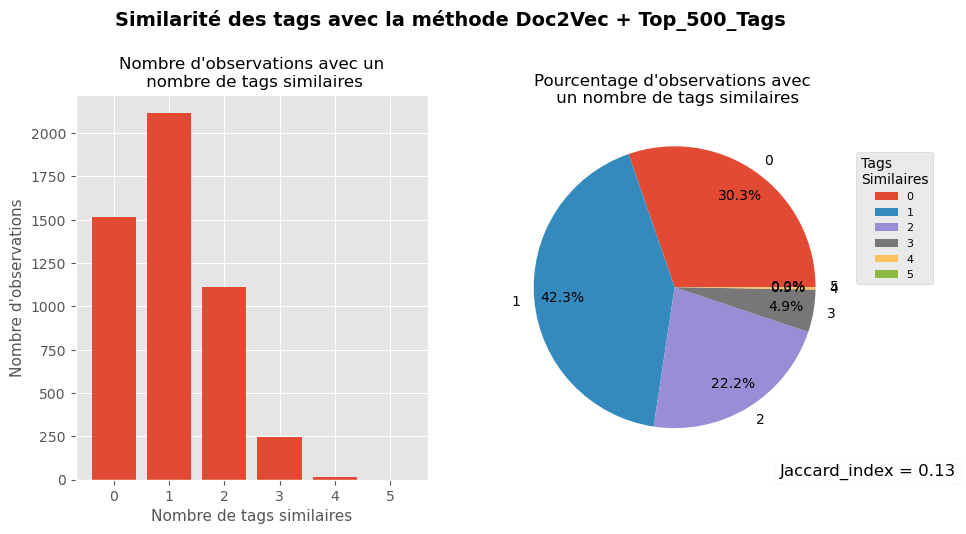

In [28]:
plot_similar_tags(true_tags, pred_tags, 'Doc2Vec + Top_500_Tags')

In [29]:
# Convert the sentences into numerical data
encoded_sentences = np.array([d2v_model.docvecs[sent.tags[0]] for sent in tagged_data])

In [30]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

In [31]:
# Define the neural network
d2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [32]:
# Compile the model
d2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model and store the history object
history = d2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=200, batch_size=32, 
                           validation_data=(test_sentences, test_tags),
                           workers=multiprocessing.cpu_count())

Epoch 1/420
125/125 [==============================] - 4s 11ms/step - loss: 0.6612 - accuracy: 0.0060 - val_loss: 0.4372 - val_accuracy: 0.1350
Epoch 2/420
125/125 [==============================] - 1s 8ms/step - loss: 0.2341 - accuracy: 0.1475 - val_loss: 0.0923 - val_accuracy: 0.2820
Epoch 3/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0726 - accuracy: 0.2625 - val_loss: 0.0519 - val_accuracy: 0.3010
Epoch 4/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0537 - accuracy: 0.2812 - val_loss: 0.0449 - val_accuracy: 0.3320
Epoch 5/420
125/125 [==============================] - 1s 10ms/step - loss: 0.0485 - accuracy: 0.2862 - val_loss: 0.0431 - val_accuracy: 0.3420
Epoch 6/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0462 - accuracy: 0.2848 - val_loss: 0.0420 - val_accuracy: 0.3580
Epoch 7/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0448 - accuracy: 0.3002 - val_loss: 0.0413 - val_accuracy: 0.36

Epoch 58/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0319 - accuracy: 0.3980 - val_loss: 0.0310 - val_accuracy: 0.4450
Epoch 59/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0319 - accuracy: 0.3898 - val_loss: 0.0309 - val_accuracy: 0.4370
Epoch 60/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0317 - accuracy: 0.4005 - val_loss: 0.0308 - val_accuracy: 0.4320
Epoch 61/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0315 - accuracy: 0.4060 - val_loss: 0.0308 - val_accuracy: 0.4290
Epoch 62/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0317 - accuracy: 0.3960 - val_loss: 0.0307 - val_accuracy: 0.4470
Epoch 63/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0316 - accuracy: 0.3845 - val_loss: 0.0307 - val_accuracy: 0.4510
Epoch 64/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0314 - accuracy: 0.3882 - val_loss: 0.0307 - val_accuracy:

Epoch 115/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0292 - accuracy: 0.4040 - val_loss: 0.0300 - val_accuracy: 0.4530
Epoch 116/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0291 - accuracy: 0.4067 - val_loss: 0.0300 - val_accuracy: 0.4240
Epoch 117/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0291 - accuracy: 0.3963 - val_loss: 0.0300 - val_accuracy: 0.4430
Epoch 118/420
125/125 [==============================] - 1s 6ms/step - loss: 0.0292 - accuracy: 0.4002 - val_loss: 0.0301 - val_accuracy: 0.4640
Epoch 119/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0291 - accuracy: 0.4030 - val_loss: 0.0301 - val_accuracy: 0.4600
Epoch 120/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0288 - accuracy: 0.4053 - val_loss: 0.0301 - val_accuracy: 0.4450
Epoch 121/420
125/125 [==============================] - 1s 6ms/step - loss: 0.0289 - accuracy: 0.4105 - val_loss: 0.0301 - val_ac

125/125 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.4178 - val_loss: 0.0299 - val_accuracy: 0.4520
Epoch 228/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.4248 - val_loss: 0.0298 - val_accuracy: 0.4590
Epoch 229/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.4227 - val_loss: 0.0301 - val_accuracy: 0.4610
Epoch 230/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.4293 - val_loss: 0.0299 - val_accuracy: 0.4490
Epoch 231/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.4200 - val_loss: 0.0300 - val_accuracy: 0.4500
Epoch 232/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.4255 - val_loss: 0.0299 - val_accuracy: 0.4580
Epoch 233/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.4280 - val_loss: 0.0299 - val_accuracy: 0.4400

125/125 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.4340 - val_loss: 0.0298 - val_accuracy: 0.4330
Epoch 340/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.4358 - val_loss: 0.0299 - val_accuracy: 0.4590
Epoch 341/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.4370 - val_loss: 0.0300 - val_accuracy: 0.4590
Epoch 342/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.4375 - val_loss: 0.0298 - val_accuracy: 0.4490
Epoch 343/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.4355 - val_loss: 0.0298 - val_accuracy: 0.4620
Epoch 344/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.4453 - val_loss: 0.0299 - val_accuracy: 0.4600
Epoch 345/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.4330 - val_loss: 0.0299 - val_accuracy: 0.4450

In [34]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

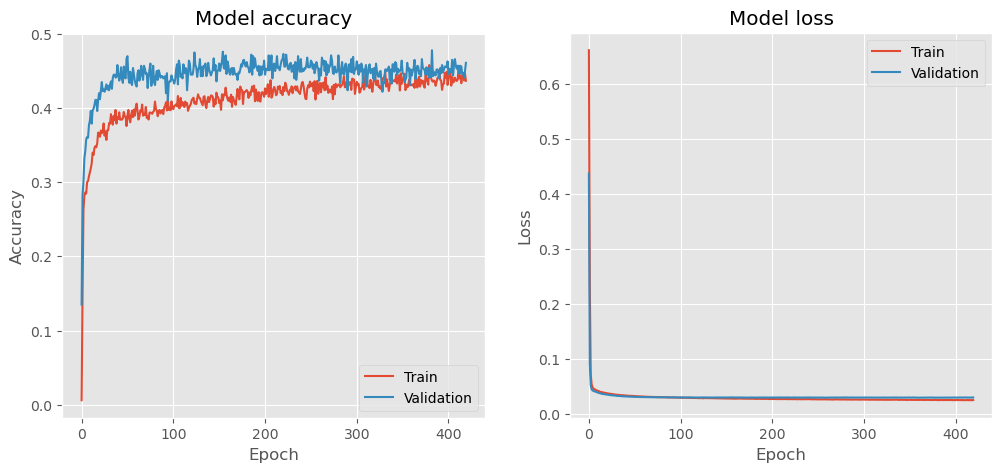

In [35]:
plot_epochs(history)

In [36]:
# Use the trained model to predict the tags for each sentence
pred_probs = d2v_nn_model.predict(encoded_sentences)

157/157 [==============================] - 0s 834us/step


In [37]:
# Find the top 5 tags for each sentence
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [38]:
pred_tags[0:5]

[['spring', 'java', 'jpa', 'spring-mvc', 'spring-data'],
 ['python', 'django', 'java', 'django-rest-framework', 'spring'],
 ['c#', '.net', 'ios', 'iphone', 'android'],
 ['java', 'spring', 'maven', 'tomcat', 'spring-boot'],
 ['java', 'spring', 'hibernate', 'jpa', 'spring-data-jpa']]

In [39]:
true_tags[0:5]

[['java', 'spring', 'rest', 'jpa', 'spring-data'],
 ['java', 'django', 'frameworks', 'comparison', 'playframework'],
 ['android', 'iphone', 'asp.net', 'web-services', 'push-notification'],
 ['java', 'spring', 'maven', 'spring-boot', 'maven-3'],
 ['java', 'sql', 'spring', 'jpa', 'spring-data-jpa']]

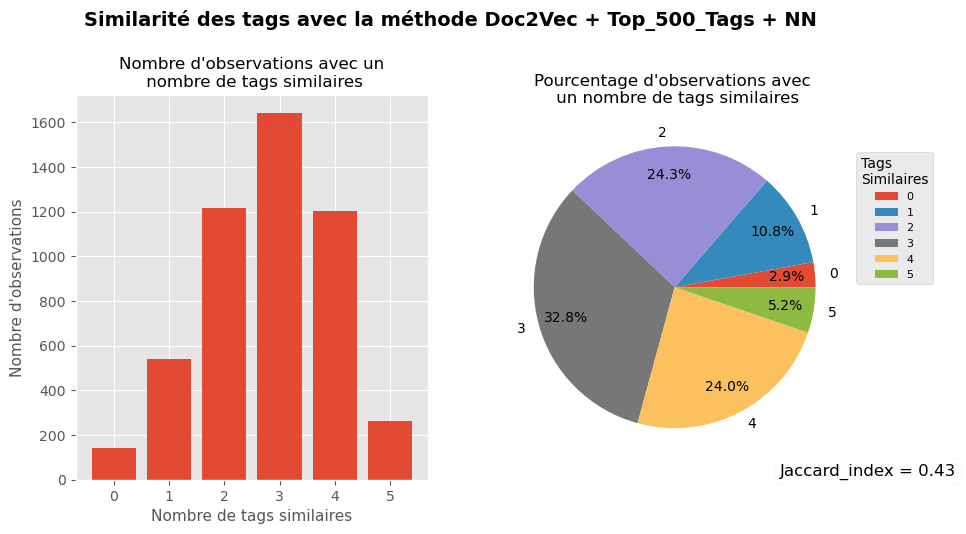

In [40]:
plot_similar_tags(true_tags, pred_tags, 'Doc2Vec + Top_500_Tags + NN')

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

In [41]:
# Train a Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=2, min_count=1, workers=4)

In [42]:
# Convert the sentences into numerical data
encoded_sentences = []
for sentence in sentences:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences.append(sentence_vector)

encoded_sentences = np.array(encoded_sentences)

In [43]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

In [44]:
# Define the neural network
w2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [45]:
# Compile the model
w2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model and store the history object
history = w2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=200, batch_size=32, 
                           validation_data=(test_sentences, test_tags))

Epoch 1/420
125/125 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.0035 - val_loss: 0.4092 - val_accuracy: 0.0350
Epoch 2/420
125/125 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.0852 - val_loss: 0.0788 - val_accuracy: 0.2110
Epoch 3/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.1602 - val_loss: 0.0517 - val_accuracy: 0.2150
Epoch 4/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.1797 - val_loss: 0.0475 - val_accuracy: 0.2520
Epoch 5/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.1898 - val_loss: 0.0461 - val_accuracy: 0.2280
Epoch 6/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.1945 - val_loss: 0.0462 - val_accuracy: 0.2620
Epoch 7/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.2050 - val_loss: 0.0457 - val_accuracy: 0.2510

Epoch 58/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.3345 - val_loss: 0.0360 - val_accuracy: 0.4200
Epoch 59/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0373 - accuracy: 0.3340 - val_loss: 0.0362 - val_accuracy: 0.3860
Epoch 60/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.3282 - val_loss: 0.0367 - val_accuracy: 0.3800
Epoch 61/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0371 - accuracy: 0.3402 - val_loss: 0.0358 - val_accuracy: 0.4000
Epoch 62/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.3305 - val_loss: 0.0358 - val_accuracy: 0.4180
Epoch 63/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0371 - accuracy: 0.3345 - val_loss: 0.0358 - val_accuracy: 0.4230
Epoch 64/420
125/125 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.3380 - val_loss: 0.0360 - val_accuracy:

Epoch 115/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0361 - accuracy: 0.3635 - val_loss: 0.0351 - val_accuracy: 0.4150
Epoch 116/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0360 - accuracy: 0.3630 - val_loss: 0.0347 - val_accuracy: 0.4330
Epoch 117/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0360 - accuracy: 0.3645 - val_loss: 0.0348 - val_accuracy: 0.4220
Epoch 118/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0361 - accuracy: 0.3575 - val_loss: 0.0348 - val_accuracy: 0.4030
Epoch 119/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0363 - accuracy: 0.3560 - val_loss: 0.0350 - val_accuracy: 0.3670
Epoch 120/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0362 - accuracy: 0.3540 - val_loss: 0.0349 - val_accuracy: 0.4170
Epoch 121/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0361 - accuracy: 0.3697 - val_loss: 0.0349 - val_ac

125/125 [==============================] - 1s 8ms/step - loss: 0.0352 - accuracy: 0.3600 - val_loss: 0.0343 - val_accuracy: 0.4020
Epoch 228/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0350 - accuracy: 0.3650 - val_loss: 0.0343 - val_accuracy: 0.4260
Epoch 229/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0352 - accuracy: 0.3665 - val_loss: 0.0347 - val_accuracy: 0.4150
Epoch 230/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0351 - accuracy: 0.3570 - val_loss: 0.0341 - val_accuracy: 0.4320
Epoch 231/420
125/125 [==============================] - 1s 9ms/step - loss: 0.0350 - accuracy: 0.3600 - val_loss: 0.0346 - val_accuracy: 0.4380
Epoch 232/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0353 - accuracy: 0.3607 - val_loss: 0.0343 - val_accuracy: 0.4170
Epoch 233/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0353 - accuracy: 0.3695 - val_loss: 0.0344 - val_accuracy: 0.4070

125/125 [==============================] - 1s 9ms/step - loss: 0.0348 - accuracy: 0.3702 - val_loss: 0.0338 - val_accuracy: 0.4390
Epoch 340/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0347 - accuracy: 0.3670 - val_loss: 0.0338 - val_accuracy: 0.4420
Epoch 341/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0348 - accuracy: 0.3658 - val_loss: 0.0336 - val_accuracy: 0.4420
Epoch 342/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0347 - accuracy: 0.3557 - val_loss: 0.0342 - val_accuracy: 0.4340
Epoch 343/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0346 - accuracy: 0.3627 - val_loss: 0.0341 - val_accuracy: 0.4280
Epoch 344/420
125/125 [==============================] - 1s 8ms/step - loss: 0.0347 - accuracy: 0.3825 - val_loss: 0.0340 - val_accuracy: 0.4170
Epoch 345/420
125/125 [==============================] - 1s 7ms/step - loss: 0.0346 - accuracy: 0.3758 - val_loss: 0.0337 - val_accuracy: 0.4270

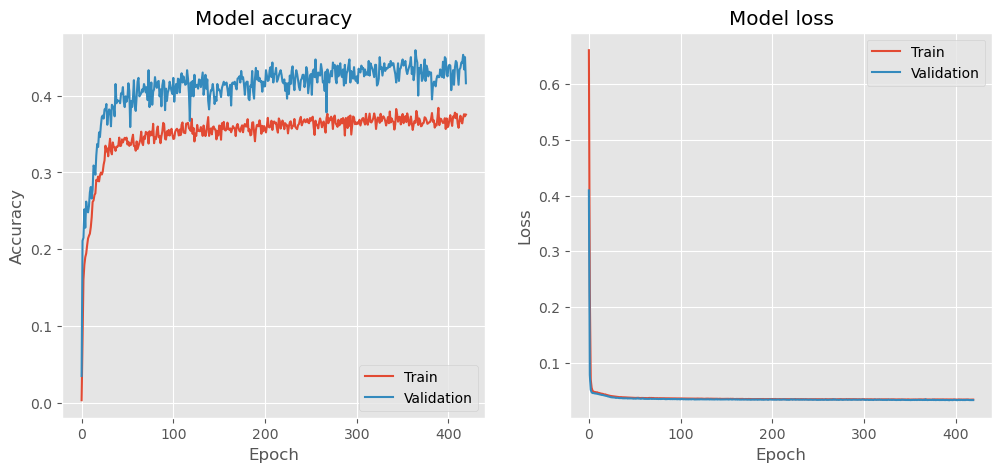

In [47]:
plot_epochs(history)

In [48]:
# Use the trained model to predict the tags for each sentence
pred_probs = w2v_nn_model.predict(encoded_sentences)

157/157 [==============================] - 1s 3ms/step


In [49]:
# Find the top 5 tags for each sentence
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [50]:
pred_tags[0:5]

[['java', 'spring', 'spring-mvc', 'hibernate', 'json'],
 ['java', 'spring', 'c#', 'spring-mvc', 'spring-boot'],
 ['java', 'android', 'ios', 'iphone', 'javascript'],
 ['java', 'spring', 'spring-boot', 'tomcat', 'maven'],
 ['java', 'spring', 'hibernate', 'jpa', 'spring-data-jpa']]

In [51]:
true_tags[0:5]

[['java', 'spring', 'rest', 'jpa', 'spring-data'],
 ['java', 'django', 'frameworks', 'comparison', 'playframework'],
 ['android', 'iphone', 'asp.net', 'web-services', 'push-notification'],
 ['java', 'spring', 'maven', 'spring-boot', 'maven-3'],
 ['java', 'sql', 'spring', 'jpa', 'spring-data-jpa']]

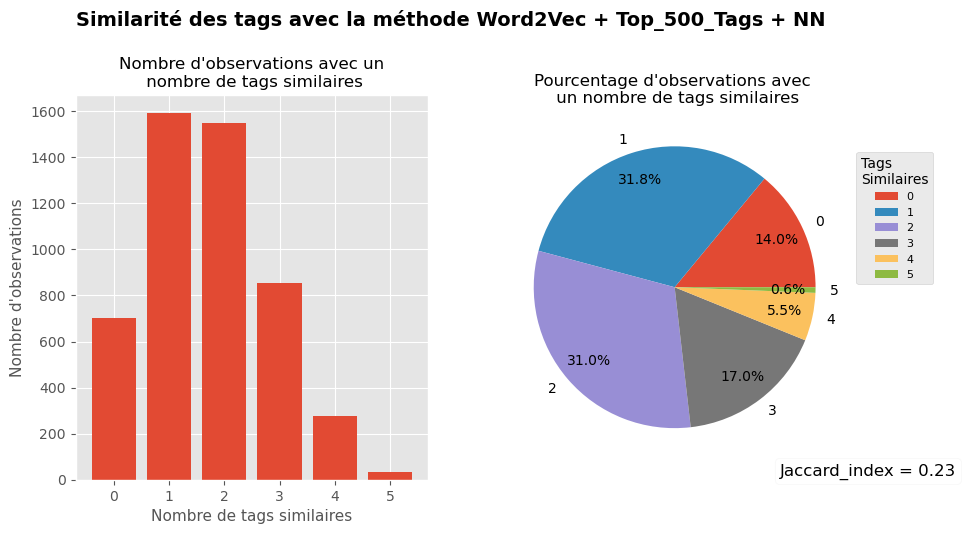

In [52]:
plot_similar_tags(true_tags, pred_tags, 'Word2Vec + Top_500_Tags + NN')

# ON UNSEEN DATA !

In [53]:
sentences_ = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]

In [54]:
# Convert the sentences into numerical data
encoded_sentences_ = []
for sentence in sentences_:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences_.append(sentence_vector)

encoded_sentences_ = np.array(encoded_sentences_)

In [55]:
pred_probs_ = w2v_nn_model.predict(encoded_sentences_)

157/157 [==============================] - 0s 3ms/step


In [56]:
# Find the top 5 tags for each sentence
pred_tags_ = []
for sentence_probs in pred_probs_:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_.append([mlb.classes_[i] for i in top_indexes])

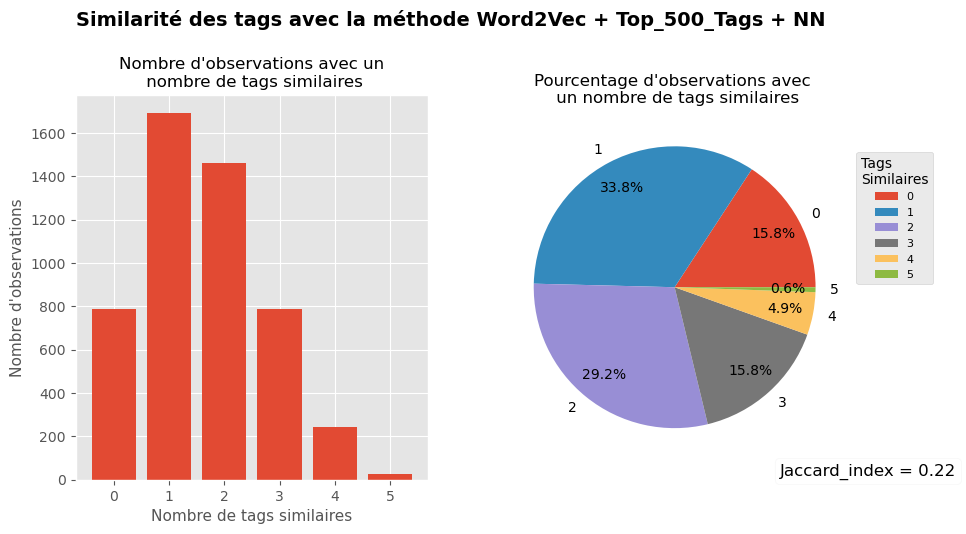

In [57]:
plot_similar_tags(tags_list_eval, pred_tags_, 'Word2Vec + Top_500_Tags + NN')